In [4]:
#pip install tweepy

Note: you may need to restart the kernel to use updated packages.


# <font color='crimson'>Data Gathering Process</font>

In [180]:
import tweepy as tw
import pandas as pd
import numpy as np

import os
import requests
import json
import re

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

pd.set_option('display.max_colwidth', 500)

In [181]:
import warnings
warnings.filterwarnings("ignore")

In [182]:
# Part 1, get WeRateDogs Twitter archive, save data in df1

df1 = pd.read_csv('twitter_archive_enhanced.csv')
df1.shape

(2356, 17)

In [183]:
# Part 2, get tweet image predictions, save data in df2

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
tsv_file = open('tweet_image_predictions.tsv', 'wb')
tsv_file.write(response.content)
df2 = pd.read_csv('tweet_image_predictions.tsv', sep = '\t')
df2.shape

(2075, 12)

In [184]:
df2.isnull().sum().any()

False

In [185]:
# Part 3, get additional tweet attributes, save data in df3

#consumer_key = "kNpInx6nTmMg98WhCTag3je8P"
#consumer_secret = "Pu2CRE0jifgIL0vz36guRXveUarhu2xxuuhDhtnJmAkMqYQ9Gp"
#access_token = "1874013096-j8ai8JDdExj6JaGCMxKfkJoNbNnMHdRjWIpZULt"
#access_token_secret = "YvlmTYjgjIVB03KxqjPVHLpK7FWS2rKTImhbYTZCOykOV"

#auth = tw.OAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_token, access_token_secret)
#api = tw.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [186]:
#tweet_ids = df1.tweet_id.values
#count = 0
#error_dict = []
#with open('tweet_json.txt', 'w') as file:
#    for i in tweet_ids:
#        count = count + 1
#        print("No." + str(count) + ": " + str(i))        
#        try:
#            tweet = api.get_status(i, tweet_mode='extended')
#            print("Success")
#            json.dump(tweet._json, file)
#            file.write('\n')
#        except:
#            print("Fail")
#            error_dict.append(i)
#            pass

In [187]:
# print('There are ' + str(len(error_dict)) + ' broken tweets whose status cannot be retrieved.')

In [188]:
df3 = pd.DataFrame(columns=['tweet_id', 'retweet_count', 'favorite_count'])
with open('tweet_json.txt') as file:
    for line in file:
        status = json.loads(line)
        id_str = status['id_str']
        retweet_count = status['retweet_count']
        favorite_count = status['favorite_count']
        df3 = df3.append(pd.DataFrame([[id_str, retweet_count, favorite_count]], 
                                      columns=['tweet_id', 'retweet_count', 'favorite_count']))
df3 = df3.reset_index(drop = True)
df3.isnull().sum()

tweet_id          0
retweet_count     0
favorite_count    0
dtype: int64

In [189]:
# create backups before cleaning process

df1_clean = df1
df2_clean = df2
df3_clean = df3

In [190]:
df1.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [191]:
df2.isnull().sum().any()

False

In [192]:
df3.isnull().sum().any()

False

# <font color='crimson'>Data Assessing and Cleaning Process</font>

### Quality Issue 1: Delete Retweets

In [193]:
df1[df1.retweeted_status_id.notnull()].head(1) # find a retweet

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None


In [194]:
retweet_no_example = df1.retweeted_status_id[19]
df1[df1.tweet_id == retweet_no_example] # confirmed that retweet and the original rating are talking about the same dog

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
23,887473957103951883,NaN,NaN,2017-07-19 00:47:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None


In [195]:
retweet_index = df1[df1.retweeted_status_id.notnull()].index
df1.drop(retweet_index, inplace=True)

In [196]:
df1.retweeted_status_id.unique()

array([nan])

In [197]:
df1.retweeted_status_user_id.unique()

array([nan])

In [198]:
df1.retweeted_status_timestamp.unique() # all values in retweet related columns are deleted

array([nan], dtype=object)

In [199]:
df1.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], 
         axis = 1, inplace = True) # delete those columns

In [200]:
df1.isnull().sum()

tweet_id                    0
in_reply_to_status_id    2097
in_reply_to_user_id      2097
timestamp                   0
source                      0
text                        0
expanded_urls              58
rating_numerator            0
rating_denominator          0
name                        0
doggo                       0
floofer                     0
pupper                      0
puppo                       0
dtype: int64

### Quality Issue 2: Drop Useless Columns

In [201]:
index1 = df1[df1.in_reply_to_status_id.notnull()].index
index2 = df1[df1.in_reply_to_user_id.notnull()].index
(index1 == index2).all()

True

In [202]:
in_reply = []
for i in range(df1.shape[0]):
    if i in index1:
        in_reply.append(1)
    else:
        in_reply.append(0)
df1 = df1.assign(in_reply = in_reply) # add a column to indicate whether the original rating is a reply or not

In [203]:
df1.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], 
         axis = 1, inplace = True) # delete those columns

### Quality Issue 3: Change Wrong Datatypes

In [204]:
df1.dtypes #timestamps shall be datetypes and id values shall be strings

tweet_id               int64
timestamp             object
source                object
text                  object
expanded_urls         object
rating_numerator       int64
rating_denominator     int64
name                  object
doggo                 object
floofer               object
pupper                object
puppo                 object
in_reply               int64
dtype: object

In [205]:
df1.timestamp = pd.to_datetime(df1.timestamp)
df1.tweet_id = df1.tweet_id.astype(str)

In [206]:
df1.dtypes

tweet_id                           object
timestamp             datetime64[ns, UTC]
source                             object
text                               object
expanded_urls                      object
rating_numerator                    int64
rating_denominator                  int64
name                               object
doggo                              object
floofer                            object
pupper                             object
puppo                              object
in_reply                            int64
dtype: object

### Quality Issue 4: Simplify Source

In [207]:
df1.source.unique() # there only 4 types of source and these data took large spaces

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [208]:
simplified_source = []
for i in df1.source:
    if 'iPhone' in i:
        simplified_source.append('iPhone')
    elif 'Web' in i:
        simplified_source.append('Web Client')
    elif 'Vine' in i:
        simplified_source.append('Vine')
    elif 'Deck' in i:
        simplified_source.append('TweetDeck')
    else:
        print('Method needs to be fixed')

In [209]:
df1.source = simplified_source

### Quality Issue 5: Delete Duplicated URLs

In [210]:
df1[df1.expanded_urls.isnull()].head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,in_reply
30,886267009285017600,2017-07-15 16:51:35+00:00,iPhone,@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,12,10,None,None,None,None,None,0
55,881633300179243008,2017-07-02 21:58:53+00:00,iPhone,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,17,10,None,None,None,None,None,0
64,879674319642796034,2017-06-27 12:14:36+00:00,iPhone,@RealKentMurphy 14/10 confirmed,NaN,14,10,None,None,None,None,None,0
113,870726314365509632,2017-06-02 19:38:25+00:00,iPhone,@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,10,10,None,None,None,None,None,0
148,863427515083354112,2017-05-13 16:15:35+00:00,iPhone,"@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,12,10,None,None,None,None,None,0


In [211]:
df1[df1.expanded_urls.isnull()].text[55] # just no URLs for those rows

'@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s'

In [212]:
df1.drop(df1[df1.expanded_urls.isnull()].index, inplace=True)

In [213]:
df1.isnull().sum()

tweet_id              0
timestamp             0
source                0
text                  0
expanded_urls         0
rating_numerator      0
rating_denominator    0
name                  0
doggo                 0
floofer               0
pupper                0
puppo                 0
in_reply              0
dtype: int64

In [214]:
var = 0
for i in df1.expanded_urls:
    if ',' in i:
        urls = i.split(',')
        print(urls)
        var += 1
    if var > 10:
        break 
# for a tweet with N photos, N identical twitter URLs will be found, sometimes we can see gofundme or other URLs at first

['https://twitter.com/dog_rates/status/891327558926688256/photo/1', 'https://twitter.com/dog_rates/status/891327558926688256/photo/1']
['https://gofundme.com/ydvmve-surgery-for-jax', 'https://twitter.com/dog_rates/status/890971913173991426/photo/1']
['https://twitter.com/dog_rates/status/890729181411237888/photo/1', 'https://twitter.com/dog_rates/status/890729181411237888/photo/1']
['https://twitter.com/dog_rates/status/890006608113172480/photo/1', 'https://twitter.com/dog_rates/status/890006608113172480/photo/1']
['https://twitter.com/dog_rates/status/889638837579907072/photo/1', 'https://twitter.com/dog_rates/status/889638837579907072/photo/1']
['https://twitter.com/dog_rates/status/888804989199671297/photo/1', 'https://twitter.com/dog_rates/status/888804989199671297/photo/1']
['https://twitter.com/dog_rates/status/888554962724278272/photo/1', 'https://twitter.com/dog_rates/status/888554962724278272/photo/1', 'https://twitter.com/dog_rates/status/888554962724278272/photo/1', 'https:/

In [215]:
twitter_url = []
extra_url = []
for i in df1.expanded_urls:
    if ',' in i:
        urls = i.split(',')
        if 'twitter' in urls[0]:
            twitter_url.append(urls[0].split('/photo')[0])
            extra_url.append('None')
        else:
            twitter_url.append(urls[1].split('/photo')[0])
            extra_url.append(urls[0])
    else:
        twitter_url.append(i.split('/photo')[0])
        extra_url.append('None')

In [216]:
df1 = df1.assign(twitter_url = twitter_url)
df1 = df1.assign(extra_url = extra_url)
df1.drop(['expanded_urls'], axis = 1, inplace = True)

### Quality Issue 6: Change Wrong Dog Names

In [217]:
df1.name.value_counts() # there are 55 dogs called "a", shall be wrong inputs

None       622
a           55
Lucy        11
Charlie     11
Cooper      10
          ... 
Zooey        1
Tino         1
Jareld       1
Mark         1
Jed          1
Name: name, Length: 956, dtype: int64

In [218]:
df1[df1.name == 'a'].text.tail(20) # apparently some of those dogs do have names

2211     Here is a horned dog. Much grace. Can jump over moons (dam!). Paws not soft. Bad at barking. 7/10 can still pet tho https://t.co/2Su7gmsnZm
2218      This is a Birmingham Quagmire named Chuk. Loves to relax and watch the game while sippin on that iced mocha. 10/10 https://t.co/HvNg9JWxFt
2222         Here is a mother dog caring for her pups. Snazzy red mohawk. Doesn't wag tail. Pups look confused. Overall 4/10 https://t.co/YOHe6lf09m
2235               This is a Trans Siberian Kellogg named Alfonso. Huge ass eyeballs. Actually Dobby from Harry Potter. 7/10 https://t.co/XpseHBlAAb
2249    This is a Shotokon Macadamia mix named Cheryl. Sophisticated af. Looks like a disappointed librarian. Shh (lol) 9/10 https://t.co/J4GnJ5Swba
2255        This is a rare Hungarian Pinot named Jessiga. She is either mid-stroke or got stuck in the washing machine. 8/10 https://t.co/ZU0i0KJyqD
2264                          This is a southwest Coriander named Klint. Hat looks expensive. Still on hou

In [219]:
name_list = df1.name.unique()
wrong_name = []
for i in name_list:
    if not re.search('[A-Z]', i) or len(i) <= 1:
        wrong_name.append(i)
wrong_name.append('None') # a list of wrong names or lack of names
print(wrong_name)

['such', 'a', 'quite', 'not', 'one', 'incredibly', 'O', 'very', 'my', 'his', 'an', 'actually', 'just', 'getting', 'mad', 'this', 'unacceptable', 'all', 'old', 'infuriating', 'the', 'by', 'officially', 'life', 'light', 'space', 'None']


In [220]:
wrong_name_index = df1.query("name == @wrong_name").index
new_name = []
for i in wrong_name_index:
    words = df1.text[i].split()
    if 'named' in words:
        new_name.append(re.findall('[a-zA-Z]+', words[words.index('named')+1])[0])
    else:
        new_name.append('None') # get dog names by a new method: extract the word after "named"

In [221]:
pd.options.mode.chained_assignment = None
df1.name[wrong_name_index] = new_name
df1.name.value_counts()

None       704
Charlie     11
Lucy        11
Cooper      10
Oliver      10
          ... 
Cal          1
Rover        1
Tassy        1
Sid          1
Jed          1
Name: name, Length: 949, dtype: int64

### Quality Issue 7: Standardize and Correct Ratings

In [222]:
df1.rating_denominator.value_counts() # need to fix denominators above 10

10     2099
50        3
11        2
80        2
7         1
170       1
150       1
130       1
120       1
110       1
90        1
70        1
40        1
20        1
2         1
Name: rating_denominator, dtype: int64

In [223]:
df1[df1.rating_denominator < 10].twitter_url

516     https://twitter.com/dog_rates/status/810984652412424192
2335    https://twitter.com/dog_rates/status/666287406224695296
Name: twitter_url, dtype: object

In [224]:
print(df1.text[516])
print('----')
print(df1.text[2335])

Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
----
This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv


In [225]:
df1.drop(516, inplace=True) # no ratings given for Sam, should delete the row

In [226]:
df1.rating_denominator[2335] = 10
df1.rating_numerator[2335] = 9 # the rating is actually 9/10, not 1/2

In [227]:
df1.timestamp.dtypes

datetime64[ns, UTC]

In [228]:
df1[df1.rating_denominator == 11].twitter_url

1068    https://twitter.com/dog_rates/status/740373189193256964
1662    https://twitter.com/dog_rates/status/682962037429899265
Name: twitter_url, dtype: object

In [229]:
print(df1.text[1068])
print('----')
print(df1.text[1662])

After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
----
This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5


In [230]:
df1.rating_denominator[1068] = 10
df1.rating_denominator[1662] = 10
df1.rating_numerator[1068] = 14
df1.rating_numerator[1662] = 10

In [231]:
df1 = df1.reset_index(drop = True)

In [232]:
index_10x = df1[df1.rating_denominator >= 20].index

In [233]:
for i in index_10x:
    print(df1.text[i])
    print('----')

The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
----
Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
----
Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
----
Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
----
This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
----
Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
----
Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
----
From left to right:
Cletus, Jerome, Alejandro, Burp, &amp; Titson
None know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK
----
Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa
----
Happy Wednesday here's a bucket of pups.

In [234]:
for i in index_10x:
    rep_num = (df1.rating_denominator[i]/10) - 1 # rows need to be replicated
    df1.rating_numerator[i] = 10*df1.rating_numerator[i]/df1.rating_denominator[i]
    df1.rating_denominator[i] = 10
#    rep_line = df1.iloc[i, :].repeat(1)
#    for h in range(int(rep_num)):
#        df1.loc[len(df1)] = rep_line # DON'T replicate rows with multiple dogs in a photo

In [235]:
df1.rating_denominator.value_counts() # finished all denominators

10    2116
Name: rating_denominator, dtype: int64

In [236]:
df1.rating_numerator.value_counts() # still problems with numerators

12      493
10      439
11      423
13      295
9       155
8        98
7        51
14       41
5        34
6        32
3        19
4        15
2        10
1         4
0         2
75        1
26        1
27        1
1776      1
420       1
Name: rating_numerator, dtype: int64

In [237]:
index_wrong_num = df1[df1.rating_numerator > 20].index
print(index_wrong_num)
for i in index_wrong_num:
    print(df1.text[i])
    print('----')

Int64Index([530, 587, 771, 1485, 1839], dtype='int64')
This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS
----
This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq
----
This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
----
Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD
----
After so many requests... here you go.

Good dogg. 420/10 https://t.co/yfAAo1gdeY
----


In [238]:
df1.rating_denominator.value_counts()

10    2116
Name: rating_denominator, dtype: int64

In [239]:
df1.rating_numerator[530] = 9.75
df1.rating_numerator[587] = 11.27
df1.rating_numerator[1485] = 11.26

# Besides, there is a very wild rating for a dog with a background of US flag: 1776 (The Declaration of Independence)
# Also, Snoop Dogg with rating of 420 (name of his song), keep it there at this moment

### Quality Issue 8: Correct Dog Categorization

In [240]:
df1 = df1.reset_index(drop = True)

In [241]:
dup_index = []
for i in range(df1.shape[0]):
    dog_type = df1.iloc[i, 7:11].values.tolist()
    num = dog_type.count('None')
    if num < 3:
        dup_index.append(i) # list for dogs got categorized for multiple times
print(dup_index)

[156, 163, 360, 417, 442, 448, 538, 563, 690, 749, 851, 900]


In [242]:
for i in dup_index:
    print(df1.text[i])
    print('----')

# here we can see the hard part: some of those category are wrong, but some of them actually contains multiple dogs

Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel
----
At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk
----
This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7
----
Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho
----
Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze
----
This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj
----
This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 w

In [243]:
df1.drop(749, inplace=True) # drop it since the pic is a couch

In [244]:
df1.doggo[156] = 'None'
df1.doggo[163] = 'None'
df1.pupper[360] = 'None'
df1.doggo[448] = 'None'
df1.pupper[538] = 'None' # change those mis-labelled dog categories

# rest will be kept since there are multiple dogs in images, will process later, all of them are pupper+doggo combinations

### Tidiness Issue 1: Unify Dog Category Columns

In [245]:
df1 = df1.reset_index(drop = True)

In [246]:
dup_index_new = []
for i in range(df1.shape[0]):
    dog_type = df1.iloc[i, 7:11].values.tolist()
    num = dog_type.count('None')
    if num < 3:
        dup_index_new.append(i) # list for 2 dogs in 1 image rows, they need to be replicated
print(dup_index_new)

[417, 442, 563, 690, 850, 899]


In [247]:
for i in dup_index_new:
    df1.pupper[i] = 'None'
    rep_row = df1.iloc[i, :].repeat(1)
    rep_row.doggo = 'None'
    rep_row.pupper = 'pupper'
    df1.loc[len(df1)] = rep_row

In [248]:
df1.shape

(2121, 14)

In [249]:
category = []
for i in range(df1.shape[0]):
    if df1.doggo[i] == 'doggo':
        category.append('doggo')
    elif df1.floofer[i] == 'floofer':
        category.append('floofer')
    elif df1.pupper[i] == 'pupper':
        category.append('pupper')
    elif df1.puppo[i] == 'puppo':
        category.append('puppo')
    else:
        category.append('unknown')
df1 = df1.assign(category = category)

In [250]:
df1.drop(['doggo', 'floofer', 'pupper', 'puppo'], 
         axis = 1, inplace = True) # delete those columns

### Tidiness Issue 2: Repeated ID Removal

In [251]:
df2.tweet_id = df2.tweet_id.astype(str)
df3.tweet_id = df3.tweet_id.astype(str)
df3.retweet_count = df3.retweet_count.astype(int)
df3.favorite_count = df3.favorite_count.astype(int)

In [252]:
df2.tweet_id.value_counts() # no repeated ID in df2

763837565564780549    1
680055455951884288    1
666739327293083650    1
827324948884643840    1
715220193576927233    1
                     ..
668237644992782336    1
691675652215414786    1
714258258790387713    1
854365224396361728    1
709918798883774466    1
Name: tweet_id, Length: 2075, dtype: int64

In [253]:
df3.tweet_id.value_counts() # there are repeated IDs in df3

731156023742988288    17
758467244762497024    15
684225744407494656    13
677716515794329600    12
684222868335505415    11
                      ..
747461612269887489     1
813066809284972545     1
669625907762618368     1
861383897657036800     1
709918798883774466     1
Name: tweet_id, Length: 2096, dtype: int64

In [254]:
df3.drop_duplicates(inplace=True)

In [255]:
df3.tweet_id.value_counts() # there are still few duplicated ones

675853064436391936    2
758467244762497024    2
722974582966214656    2
733109485275860992    2
763837565564780549    1
                     ..
813066809284972545    1
669625907762618368    1
861383897657036800    1
682242692827447297    1
709918798883774466    1
Name: tweet_id, Length: 2096, dtype: int64

In [256]:
df3[df3.tweet_id == '722974582966214656'] # the second one is the correct one, same for rest pairs

,tweet_id,retweet_count,favorite_count
934,722974582966214656,1478,3906
2132,722974582966214656,1478,3904


In [257]:
list_sp = df3.tweet_id.value_counts()
for i in list_sp[list_sp > 1].index:
    df3.drop(df3[df3.tweet_id == i].index[1], inplace = True)

In [258]:
df3 = df3.reset_index(drop = True)

### Tidiness Issue 3: Data Combination

In [259]:
df0 = pd.merge(df1, df2, on='tweet_id')
df = pd.merge(df0, df3, on='tweet_id')
df.shape

(1979, 24)

In [260]:
df.isnull().sum().any()

False

In [389]:
df.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'in_reply', 'twitter_url', 'extra_url',
       'category', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweet_count',
       'favorite_count'],
      dtype='object')

In [262]:
df.drop_duplicates(inplace = True)
df = df.reset_index(drop = True)

In [263]:
df.to_csv('twitter_archive_master.csv') 

### <font color='crimson'>Warning: most "dogs" under a rating of 8 are actually not dogs...</font>

In [264]:
df[df.rating_numerator < 8].twitter_url # try to click on these pics...

39      https://twitter.com/dog_rates/status/883482846933004288
176     https://twitter.com/dog_rates/status/848212111729840128
232     https://twitter.com/dog_rates/status/835152434251116546
527     https://twitter.com/dog_rates/status/781661882474196992
550     https://twitter.com/dog_rates/status/777885040357281792
                                 ...                           
1965    https://twitter.com/dog_rates/status/666082916733198337
1972    https://twitter.com/dog_rates/status/666051853826850816
1974    https://twitter.com/dog_rates/status/666049248165822465
1975    https://twitter.com/dog_rates/status/666044226329800704
1977    https://twitter.com/dog_rates/status/666029285002620928
Name: twitter_url, Length: 164, dtype: object

# <font color='crimson'>Brief Data Analysis</font>

In [265]:
df.describe()

,rating_numerator,rating_denominator,in_reply,img_num,p1_conf,p2_conf,p3_conf,retweet_count,favorite_count
count,1979.000000,1979.0,1979.000000,1979.000000,1979.000000,1.979000e+03,1.979000e+03,1979.000000,1979.000000
mean,11.438605,10.0,0.033855,1.202628,0.593227,1.344784e-01,6.041482e-02,2338.812532,7980.594745
std,39.745635,0.0,0.180903,0.560652,0.271798,1.004141e-01,5.089394e-02,4192.278493,11771.830857
min,0.000000,10.0,0.000000,1.000000,0.044333,1.011300e-08,1.740170e-10,11.000000,69.000000
25%,10.000000,10.0,0.000000,1.000000,0.362715,5.409535e-02,1.631530e-02,521.000000,1687.000000
50%,11.000000,10.0,0.000000,1.000000,0.587342,1.175660e-01,4.965610e-02,1124.000000,3556.000000
75%,12.000000,10.0,0.000000,1.000000,0.843579,1.953115e-01,9.203645e-02,2662.000000,9892.000000
max,1776.000000,10.0,1.000000,4.000000,1.000000,4.880140e-01,2.734190e-01,73694.000000,149527.000000


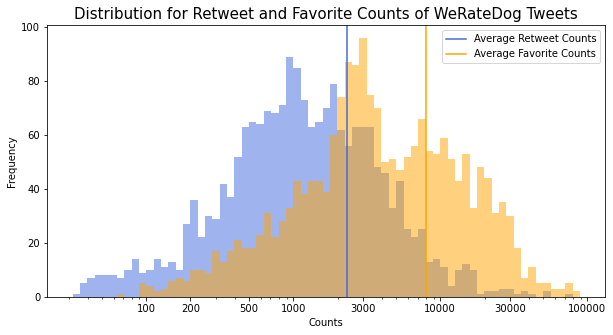

In [271]:
plt.figure(figsize=(10, 5));
bins = 10**np.arange(1.5, 5, 0.05);
retweet_mean = df.retweet_count.mean()
plt.axvline(retweet_mean, color = 'royalblue')
plt.hist(data = df, x = 'retweet_count', bins = bins, color = 'royalblue', alpha = 0.5);
favorite_mean = df.favorite_count.mean()
plt.axvline(favorite_mean, color = 'orange')
plt.hist(data = df, x = 'favorite_count', bins = bins, color = 'orange', alpha = 0.5);
plt.xscale('log');
ticks = [100, 200, 500, 1000, 3000, 10000, 30000, 100000];
labels = ['{}'.format(h) for h in ticks];
plt.xticks(ticks, labels);
plt.xlabel('Counts');
plt.ylabel('Frequency');
plt.legend(labels = ['Average Retweet Counts', 'Average Favorite Counts']);
plt.title('Distribution for Retweet and Favorite Counts of WeRateDog Tweets', fontsize=15);

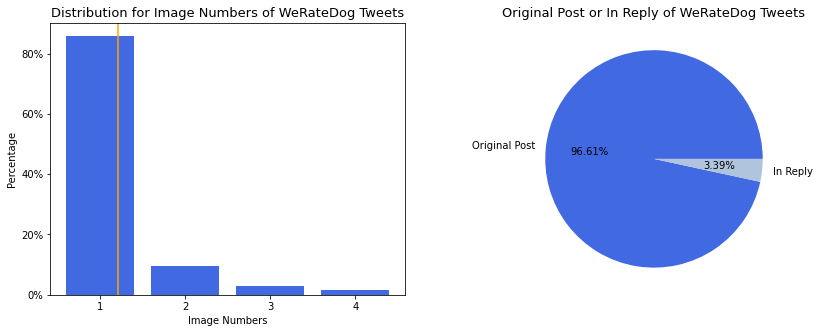

In [270]:
plt.figure(figsize=(14, 5));

plt.subplot(1, 2, 1)
image_mean = df.img_num.mean()
plt.bar(df.img_num.value_counts().index, df.img_num.value_counts()/df.img_num.value_counts().sum(), color='royalblue');
ticks = [1, 2, 3, 4];
labels = ['{}'.format(h) for h in ticks];
plt.xticks(ticks, labels);
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);
plt.axvline(image_mean, color = 'orange');
plt.xlabel('Image Numbers');
plt.ylabel('Percentage');
plt.title('Distribution for Image Numbers of WeRateDog Tweets', fontsize=13);

plt.subplot(1, 2, 2)
reply_count = df.in_reply.value_counts()
plt.pie(reply_count, labels = ['Original Post', 'In Reply'], autopct = '%.2f%%', 
        colors = ['royalblue', 'lightsteelblue']);
plt.title('Original Post or In Reply of WeRateDog Tweets', fontsize = 13);

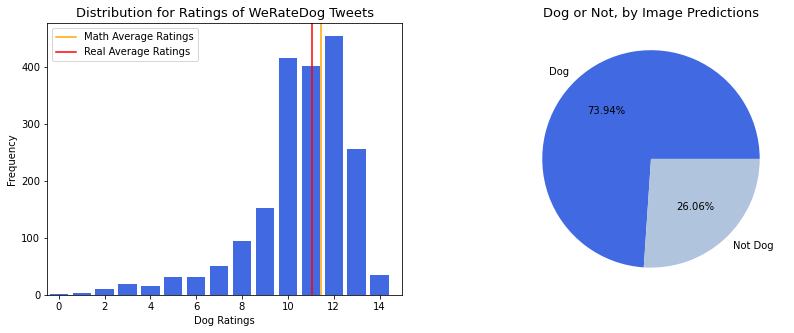

In [385]:
plt.figure(figsize=(14, 5));

plt.subplot(1, 2, 1)
ratings = df.rating_numerator.value_counts()
plt.bar(ratings.index, ratings.values, color='royalblue');
plt.xlim((-.5, 15));
plt.axvline(11.438605, color = 'orange');
mean_real = df.query("7 < rating_numerator < 20").rating_numerator.mean()
plt.axvline(mean_real, color = 'red');
plt.legend(labels = ['Math Average Ratings', 'Real Average Ratings']);
plt.xlabel('Dog Ratings');
plt.ylabel('Frequency');
plt.title('Distribution for Ratings of WeRateDog Tweets', fontsize=13);

plt.subplot(1, 2, 2)
test1 = df.p1_dog.value_counts()
test2 = df.p2_dog.value_counts()
test3 = df.p3_dog.value_counts()
test_result = test1 + test2 + test3
plt.pie(test_result, labels = ['Dog', 'Not Dog'], autopct = '%.2f%%', 
        colors = ['royalblue', 'lightsteelblue']);
plt.title('Dog or Not, by Image Predictions', fontsize = 13);

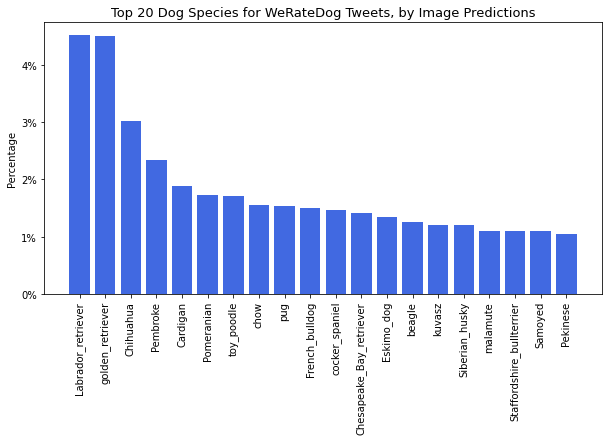

In [386]:
plt.figure(figsize=(10, 5));
prediction = df.p1.append(df.p2)
prediction = prediction.append(df.p3)
total = len(prediction)
top10_pred = prediction.value_counts()[:20]
plt.bar(top10_pred.index, top10_pred/total, color='royalblue');
plt.xticks(rotation = 90);
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);
plt.ylabel('Percentage');
plt.title('Top 20 Dog Species for WeRateDog Tweets, by Image Predictions', fontsize=13);

# <font color='crimson'>Conclusions</font>

> <li>After data cleaning, we can found most photos with ratings under 8 are not dog photos.</li><li>Only two ratings are larger than 15, one is 1776 for a dog in front of U.S. flag, and a 420 one for Snoop Dogg.</li><li>Distribution for retweet and favorite counts of WeRateDog tweets are right-skewed, with averages around 2350 and 8000 respectively.</li><li>86% of tweets only have 1 photo, while 1.5% of them have 4 photos. 3.4% of ratings are given in reply, not original posts.</li><li>Most dogs get 10~12 points out of 10, with an average of 11. Average will be smaller when exclude outliers and non-dog photos.</li><li>By image prediction, most frequent dog species are labrador retriever, golden retriever and chihuahua, and 26% images are not dogs.</li>